In [1]:
from google.colab import files
uploaded = files.upload()
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
!apt-get install -y fonts-liberation
import math


Saving training_df.tsv to training_df.tsv
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-liberation is already the newest version (1:1.07.4-11).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
uploaded.keys()

dict_keys(['training_df.tsv'])

In [3]:
#Set theme in Seaborn
sns.set_theme()
mpl.rcParams['font.family'] = ['Liberation Serif', 'serif']
mpl.rcParams['font.serif'] = ['Liberation Serif']
mpl.rcParams['axes.unicode_minus'] = False  # avoid minus rendering issues
sns.set_theme(context='notebook', style='white', palette='viridis', font='Liberation Serif', font_scale=1.1)

# DATABASE IMPORT

In [4]:
df = pd.read_csv("training_df.tsv", sep = "\t")
print(df.tail())

     UniProt_ID  Class  Label  \
8016     P82916      0      5   
8017     P34164      0      5   
8018     Q9FN69      0      5   
8019     Q16617      0      5   
8020     Q6DYE4      0      5   

                                                Frag_90 SP_15  
8016  MSVVRSSVHAKWIVGKVIGTAMQKTAKVRVTRLVLDPYLLKYFNKR...   NIL  
8017  MGTTTSHPAQKKQTTKKCRAPIMSDVREKPSNAQGCEPQEMDAVSK...   NIL  
8018  MATGQNRTTVPENLKKHLAVSVRNIQWSYGIFWSVSASQSGVLEWG...   NIL  
8019  MELCRSLALLGGSLGLMFCLIALSTDFWFEAVGPTHSAHSGLWPTG...   NIL  
8020  MVSLVNSSLTCSSLTLNLLPILRTETPSLSRKRRAAYVAATSSRDV...   NIL  


In [5]:
fold_1_smaller = df[df['Class'] == 1]
fold_smaller = fold_1_smaller[fold_1_smaller['Label'] == 1]
fold_smaller = pd.concat([fold_smaller, fold_1_smaller[fold_1_smaller['Label'] == 2]])
fold_smaller = pd.concat([fold_smaller, fold_1_smaller[fold_1_smaller['Label'] == 3]])
fold_seq = fold_smaller['SP_15']

# MATRIX COMPUTATION

In [6]:
swissprot = np.array([0.0825, 0.0393, 0.0964, 0.0665,0.0552, 0.0671, 0.0579, 0.0536, 0.0406, 0.0707, 0.0410, 0.0100,
                      0.0546, 0.0227, 0.0386, 0.0292, 0.0138, 0.0590, 0.0474, 0.0685])

def compute_matrix(frag_15:pd.Series,output_arrayname:str) -> np.ndarray:
  '''Compute the position-specific weight matrix (PSWM) from a given FASTA file and save it as a .npz file.'''
  swissprot = np.array([0.0825, 0.0393, 0.0964, 0.0665,0.0552, 0.0671, 0.0579, 0.0536, 0.0406, 0.0707, 0.0410, 0.0100,
                      0.0546, 0.0227, 0.0386, 0.0292, 0.0138, 0.0590, 0.0474, 0.0685])
  alphabet = "AQLSREKTNGMWDHFYCIPV"
  pswm = np.ones((len(alphabet),len(frag_15[0])))
  seq_number = 0
  for frag in frag_15:
      seq_number += 1
      frag_m = np.zeros((len(alphabet),len(frag)))
      col = 0
      for res in frag:
        if res != "X":
          index = alphabet.index(res)
          frag_m[index][col] += 1
          col += 1
      pswm += frag_m
  pswm = (pswm/(seq_number+20))
  pswm = pswm / swissprot.reshape(-1, 1)
  pswm = np.log2(pswm)
  np.savez(output_arrayname, pswm)
  return pswm
pwsm = compute_matrix(fold_seq,"toy_pswm")

# SCORING

In [7]:
def compute_score (sequence,  window, pswm, alphabet = "AQLSREKTNGMWDHFYCIPV"):
    seq_len = len(sequence)
    scores = np.zeros(seq_len - window + 1)

    for pos in range(seq_len - window + 1):
        window_seq = sequence[pos:pos+window]
        score = 0.0
        for i, res in enumerate(window_seq):
            if res != "X":
                idx = alphabet.find(res)
                score += pswm[idx, i]
        scores[pos] = score

    return scores.max()


In [8]:
sequences = df[df['Label'] == 4]
sequences = sequences['Frag_90']
scores = np.array([])
for seq in sequences:
  score = compute_score(seq, 15, pwsm)
  #print(score)
  scores = np.append(scores, score)
print((len(scores)))

1604


# THRESHOLD SELECTION

8.65721442477617
2.3186873403967376


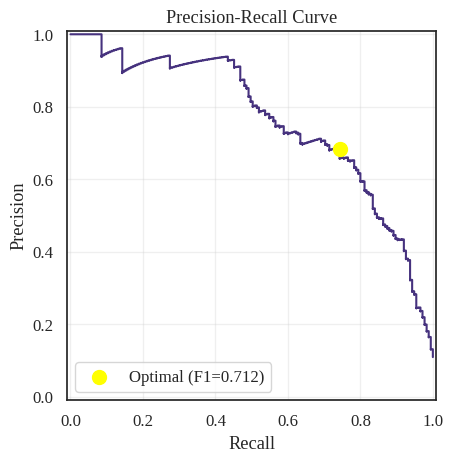

Optimal F1-score: 0.7123
Precision at optimal: 0.6842
Recall at optimal: 0.7429


In [9]:
# Find the optimal threshold for classification
classes = df[df['Label'] == 4]
classes = classes['Class']
scores
precision, recall, thresholds = precision_recall_curve(classes, scores)

fscore = (2 * precision * recall) / (precision + recall + 1e-15)

index = np.argmax(fscore)
optimal_threshold = thresholds[index]
print(optimal_threshold)
print(scores.mean())
#y_test_scores = [1.2, -6, 3.33, 4, -2, 10, -1, 7.3, -3.1, -4.4, 5.5, 6.6, -5.2, -7.3, 2.2, 0.1, -1.5, 8.8, 4.4, -3.3, -6.6]
#y_pred_test = [int(t_score >= optimal_threshold) for t_score in y_test_scores]

#print(y_pred_test)


display = PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()

# Add optimal point to the plot
optimal_precision = precision[index]
optimal_recall = recall[index]
optimal_fscore = fscore[index]

plt.scatter(optimal_recall, optimal_precision, color='yellow', s=100, label=f'Optimal (F1={optimal_fscore:.3f})', zorder=5)
plt.legend()
plt.title("Precision-Recall Curve")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal F1-score: {optimal_fscore:.4f}")
print(f"Precision at optimal: {optimal_precision:.4f}")
print(f"Recall at optimal: {optimal_recall:.4f}")

In [10]:
labels = np.array([])
data = df[df['Label'] == 5]
classes = data['Class']
print(classes.head(3))
for el in classes:
  #print(el)
  labels = np.append(labels, el)
#print(labels)
#print(predictions)
predictions = np.array([])
sequences = data['Frag_90']
scores = np.array([])
for seq in sequences:
  score = compute_score(seq, 15, pwsm)
  scores = np.append(scores, score)
print(scores)
for score in scores:
  if score >= optimal_threshold:
    predictions = np.append(predictions, 1)
  else:
    predictions = np.append(predictions, 0)
print(predictions)
print(len(sequences), len(scores),len(predictions))

700    1
701    1
702    1
Name: Class, dtype: int64
[12.44791651 17.89175132 12.30054028 ...  4.20435104  8.53004665
  2.92610469]
[1. 1. 1. ... 0. 0. 0.]
1603 1603 1603


# METRICS

In [11]:
def compute_confusion_matrix(preds, labels):
  TP, TN, FP, FN = 0,0,0,0
  for i in range(len(preds)):
    if preds[i] == labels[i] and labels[i] == 0:
      TN += 1
    elif preds[i] == labels[i] and labels[i] == 1:
      TP += 1
    elif preds[i] != labels[i] and labels[i] == 0:
      FP += 1
    elif preds[i] != labels[i] and labels[i] == 1:
      FN +=1
  return TP, FP, FN, TN
print(compute_confusion_matrix(predictions, labels))

(138, 61, 36, 1368)


In [12]:
def accuracy(TP, FP, FN, TN):
    return (TP + TN) / (TP + TN + FP + FN)
TP, FP, FN, TN = compute_confusion_matrix(predictions, labels)
print(accuracy(TP, FP, FN, TN))

0.9394884591391142


In [13]:
def mcc(TP, FP, FN, TN):
    numerator = (TP * TN) - (FP * FN)
    denominator = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return numerator / denominator if denominator != 0 else 0.0
print(mcc(TP, FP, FN, TN))

0.7079178758478392


In [14]:
def recall(TP, FP, FN, TN):
    return TP / (TP + FN) if (TP + FN) != 0 else 0.0
print(recall(TP, FP, FN, TN))
rec = recall(TP, FP, FN, TN)

0.7931034482758621


In [15]:
def precision(TP, FP, FN, TN):
    return TP / (TP + FP) if (TP + FP) != 0 else 0.0
print(precision(TP, FP, FN, TN))
prec = precision(TP, FP, FN, TN)

0.6934673366834171


In [16]:
def f1_score(prec, rec):
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0.0
print(f1_score(prec, rec))

0.739946380697051


# CROSS-VALIDATION

In [17]:
def cross_val(cycle_number:int):
  validation = []
  testing = []
  training = []
  for j in range(cycle_number):
    validation.append(j+1)
    testing.append(((j+1)%cycle_number)+1)
    training_j = []
    for i in range(cycle_number):
      if i != j and i != (j+1)%cycle_number:
        training_j.append(i+1)
    training.append(training_j)
    print("ROUND "+str(j+1))
    print("validation:", validation[j])
    print("testing:", testing[j])
    print("training:", training[j])
    print("")
    j +=1
  print("")
  print(training)
  print(validation)
  print(testing)
  return training, validation, testing
cross_val(5)


ROUND 1
validation: 1
testing: 2
training: [3, 4, 5]

ROUND 2
validation: 2
testing: 3
training: [1, 4, 5]

ROUND 3
validation: 3
testing: 4
training: [1, 2, 5]

ROUND 4
validation: 4
testing: 5
training: [1, 2, 3]

ROUND 5
validation: 5
testing: 1
training: [2, 3, 4]


[[3, 4, 5], [1, 4, 5], [1, 2, 5], [1, 2, 3], [2, 3, 4]]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 1]


([[3, 4, 5], [1, 4, 5], [1, 2, 5], [1, 2, 3], [2, 3, 4]],
 [1, 2, 3, 4, 5],
 [2, 3, 4, 5, 1])

**TRAINING (Cross-Validation)**

ROUND 1
validation: 1
testing: 2
training: [3, 4, 5]

ROUND 2
validation: 2
testing: 3
training: [1, 4, 5]

ROUND 3
validation: 3
testing: 4
training: [1, 2, 5]

ROUND 4
validation: 4
testing: 5
training: [1, 2, 3]

ROUND 5
validation: 5
testing: 1
training: [2, 3, 4]


[[3, 4, 5], [1, 4, 5], [1, 2, 5], [1, 2, 3], [2, 3, 4]]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 1]

ROUND 1
Training Set Round 1
0    SVILISRISSVGGEA
1    LLLGLLGPAACWALG
dtype: object
522    LLQLSQLLAVTQGKT
523    WFAIATLITICYAAK
dtype: object

pswm_1
[[ 0.18442457  0.51199923  0.21243895  0.15585542  1.18442457  0.97143085
   0.59946207  0.93826398  0.95494273  0.09696173  1.83392732  0.26688673
   2.51762378  1.12670907 -0.78756105]
 [-3.41813596 -3.41813596 -2.09620787 -2.41813596 -1.61078104 -0.83317346
  -0.83317346 -2.41813596  0.33675154 -0.33067312 -2.83317346  0.82979155
  -1.61078104  0.82979155  0.58186404]
 [ 2.0882601   2.11390869  1.9668403   2.06214726  1.90207005  1.70521272
   1.72198843  1.08177607 -0.58335678  

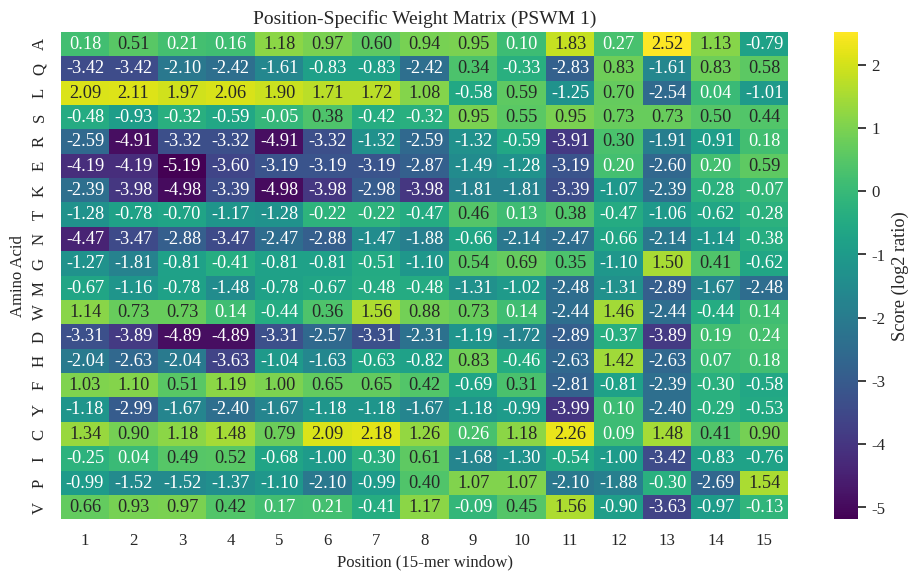

Validation Set Round 1
0    MRLLPLLRTVLWAAFLGSPLRGGSSLRHVVYWNSSNPRLLRGDAVV...
1    MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAG...
Name: Frag_90, dtype: object
2302    MDGGHSPDRHAAAAAGEPVRSRWTPKPEQILILESIFNSGMVNPPK...
2303    MAASGLDHLKNGYRRRFCRPSRARDINTEQGQNVLEILQDCFEEKS...
Name: Frag_90, dtype: object
Validation sequences processed: 1605

Optimal threshold for round 1: 8.98906076862934



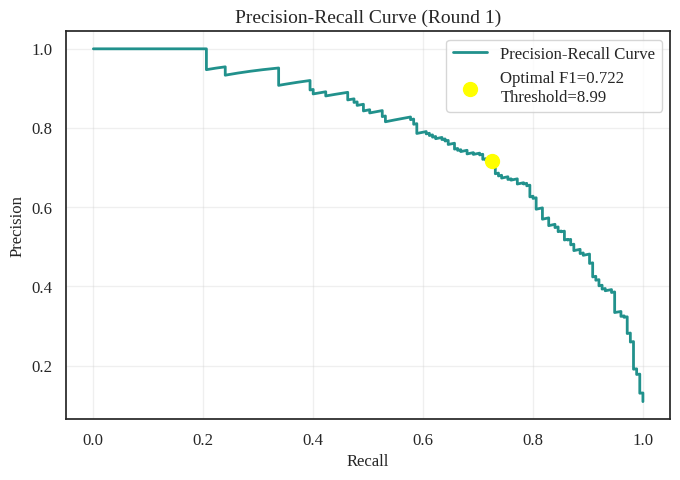

Testing Set Round 1
175    MLLILLSVALLAFSSAQDLDEDVSQEDVPLVISDGGDSEQFIDEER...
176    MDLVLKRCLLHLAVIGALLAVGATKVPRNQDWLGVSRQLRTKAWNR...
Name: Frag_90, dtype: object
3732    MDMKVVPWRLKEDFLYLMSCFYNEGQEGIPDLAALFRGVEIIQAWS...
3733    MAEPTGLLEMSELPGDSSVPQVGTASGVSDVLRGAVGGGVRVQEAR...
Name: Frag_90, dtype: object
Testing samples: 1605

TP = 123 FP = 56 FN = 52 TN = 1374


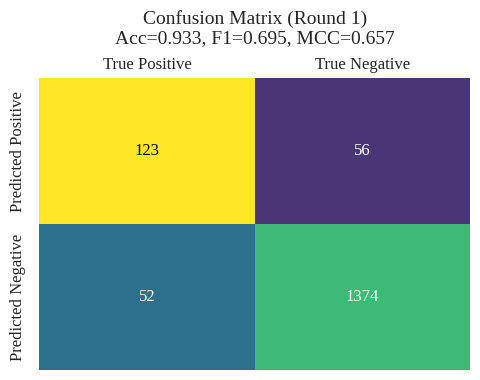


ROUND 2
Training Set Round 2
0    AAFLGSPLRGGSSLR
1    LLSCLLLTGSSSGSK
dtype: object
522    LLQLSQLLAVTQGKT
523    WFAIATLITICYAAK
dtype: object

pswm_2
[[ 3.55611852e-02  4.66195540e-01  1.84424571e-01  3.19354151e-01
   9.87732660e-01  9.87732660e-01  3.19354151e-01  8.51849232e-01
   7.40817920e-01  2.66886731e-01  1.71167157e+00 -1.66072676e-01
   2.53990523e+00  1.03556119e+00 -8.44144581e-01]
 [-3.41813596e+00 -2.83317346e+00 -1.61078104e+00 -2.83317346e+00
  -2.83317346e+00 -6.10781042e-01 -1.24821096e+00 -4.41813596e+00
   5.36060346e-01 -1.70208451e-01 -2.83317346e+00  9.03792131e-01
  -2.09620787e+00  9.39416041e-01  3.89218958e-01]
 [ 2.10114139e+00  2.16387715e+00  2.06214726e+00  2.07526276e+00
   1.99471933e+00  1.64491221e+00  1.84960263e+00  1.13285025e+00
  -6.25176957e-01  6.96751138e-01 -1.18907784e+00  4.77184761e-01
  -2.01220008e+00  9.47151241e-02 -6.25176957e-01]
 [ 3.24923735e-02 -8.55032897e-01 -5.91998491e-01 -3.18979997e-01
  -8.94981508e-02  2.82470627e-01

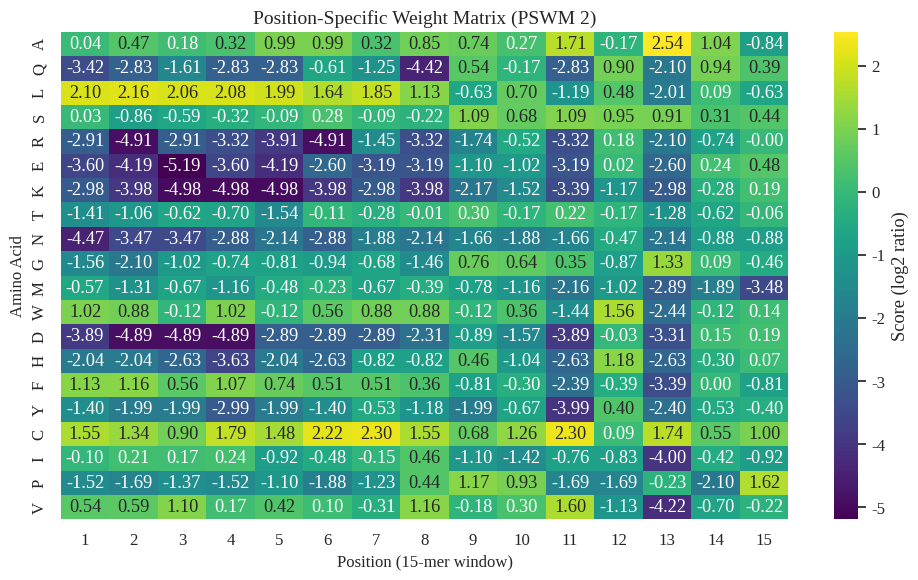

Validation Set Round 2
175    MLLILLSVALLAFSSAQDLDEDVSQEDVPLVISDGGDSEQFIDEER...
176    MDLVLKRCLLHLAVIGALLAVGATKVPRNQDWLGVSRQLRTKAWNR...
Name: Frag_90, dtype: object
3732    MDMKVVPWRLKEDFLYLMSCFYNEGQEGIPDLAALFRGVEIIQAWS...
3733    MAEPTGLLEMSELPGDSSVPQVGTASGVSDVLRGAVGGGVRVQEAR...
Name: Frag_90, dtype: object
Validation sequences processed: 1605

Optimal threshold for round 2: 8.485790663245956



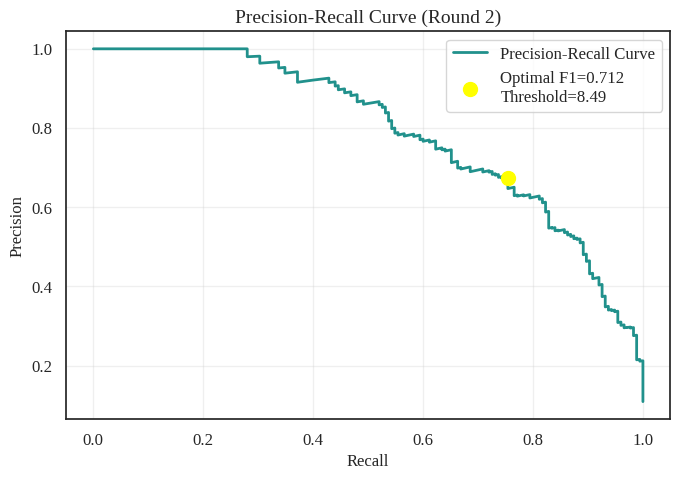

Testing Set Round 2
350    MWLLVSVILISRISSVGGEAMFCDFPKINHGILYDEEKYKPFSQVP...
351    MLPLLLGLLGPAACWALGPTPGPGSSELRSAFSAARTTPLEGTSEM...
Name: Frag_90, dtype: object
5161    MKPLPSQQPPPKMGDFYDPEHPTPEEEENEAKIENVQKTGFIKGPV...
5162    MMQTPYTTSTQGQYCHSCGMFHHHSQSCCYNNNNNSNAGSYSMVFS...
Name: Frag_90, dtype: object
Testing samples: 1604

TP = 133 FP = 89 FN = 42 TN = 1340


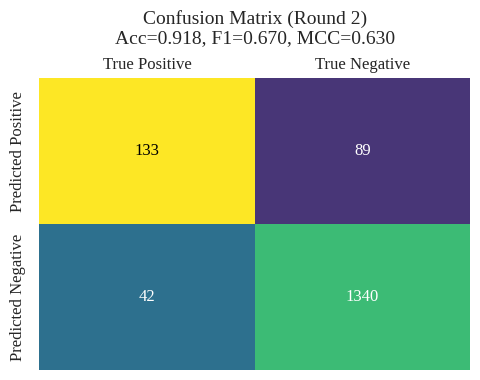


ROUND 3
Training Set Round 3
0    AAFLGSPLRGGSSLR
1    LLSCLLLTGSSSGSK
dtype: object
522    LLQLSQLLAVTQGKT
523    WFAIATLITICYAAK
dtype: object

pswm_3
[[ 4.66195540e-01  4.18889825e-01  3.69980224e-01  4.42736567e-01
   9.04316652e-01  1.09696173e+00  3.44889243e-01  6.81924231e-01
   8.15779977e-01  2.93358943e-01  1.67187057e+00 -2.40073257e-01
   2.66681734e+00  9.54942725e-01 -7.33113269e-01]
 [-3.41813596e+00 -2.83317346e+00 -1.41813596e+00 -2.41813596e+00
  -2.83317346e+00 -5.11245368e-01 -8.33173463e-01 -3.41813596e+00
   6.69326877e-01  1.05425992e-01 -3.41813596e+00  1.30978449e+00
  -2.09620787e+00  8.67266255e-01 -2.58185412e-02]
 [ 1.95978554e+00  2.12025022e+00  2.03555305e+00  2.10753916e+00
   2.02882719e+00  1.48703255e+00  1.76309363e+00  1.14534120e+00
  -7.58443488e-01  4.37107322e-01 -1.46471228e+00  4.16643219e-01
  -2.39071170e+00 -4.02144560e-02 -9.57752296e-01]
 [ 1.08441227e-01 -8.55032897e-01 -7.17529373e-01 -2.22764682e-01
  -2.22764682e-01  2.49303763e-01

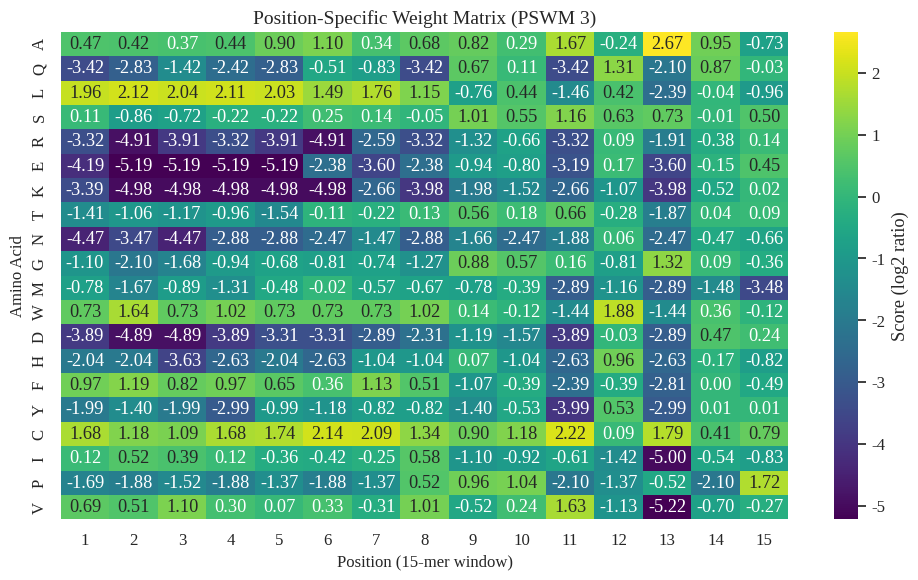

Validation Set Round 3
350    MWLLVSVILISRISSVGGEAMFCDFPKINHGILYDEEKYKPFSQVP...
351    MLPLLLGLLGPAACWALGPTPGPGSSELRSAFSAARTTPLEGTSEM...
Name: Frag_90, dtype: object
5161    MKPLPSQQPPPKMGDFYDPEHPTPEEEENEAKIENVQKTGFIKGPV...
5162    MMQTPYTTSTQGQYCHSCGMFHHHSQSCCYNNNNNSNAGSYSMVFS...
Name: Frag_90, dtype: object
Validation sequences processed: 1604

Optimal threshold for round 3: 8.068173671021889



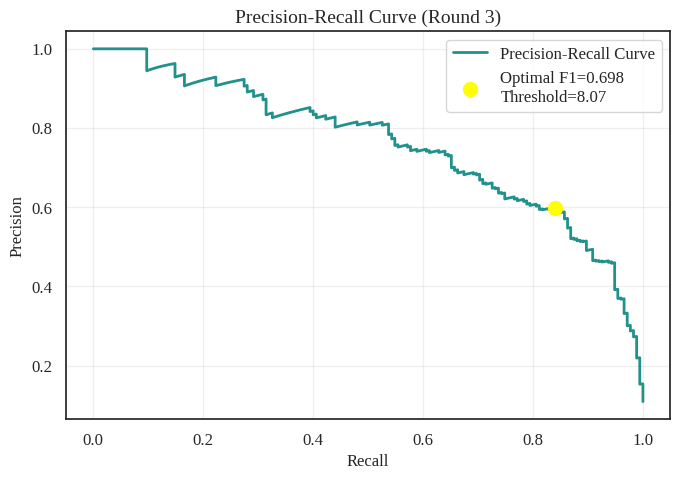

Testing Set Round 3
525    MELALRRSPVPRWLLLLPLLLGLNAGAVIDWPTEEGKEVWDYVTVR...
526    MGDHLDLLLGVVLMAGPVFGIPSCSFDGRIAFYRFCNLTQVPQVLN...
Name: Frag_90, dtype: object
6590    MALEAAFSMSFCSFSVPKAIFCERETSSFQRITSRAKGIAGESQVQ...
6591    MPHRKERPSGSSLHTHGSTGTAEGGNMSRLSLTRSPVSPLAAQGIP...
Name: Frag_90, dtype: object
Testing samples: 1604

TP = 133 FP = 74 FN = 42 TN = 1355


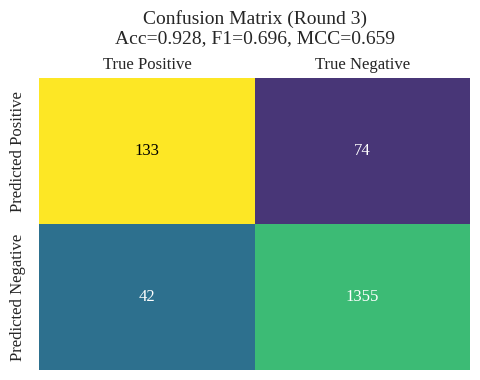


ROUND 4
Training Set Round 4
0    AAFLGSPLRGGSSLR
1    LLSCLLLTGSSSGSK
dtype: object
523    GLITASADALVTRGA
524    LLVVVCWAAAANASS
dtype: object

pswm_4
[[ 4.16240246e-01  5.53743770e-01  4.16240246e-01  6.17874108e-01
   1.09431215e+00  9.85083082e-01  4.40086988e-01  6.79274652e-01
   1.00120275e+00  1.81774993e-01  1.66922099e+00  9.43121515e-02
   2.69422499e+00  6.59096770e-01 -6.83295427e-01]
 [-4.42078554e+00 -3.42078554e+00 -1.83582304e+00 -1.83582304e+00
  -1.83582304e+00 -5.13894947e-01 -6.13430620e-01 -2.09885745e+00
   5.79214458e-01 -1.72858029e-01 -4.42078554e+00  1.36057417e+00
  -1.61343062e+00  1.16417696e+00  1.02776414e-01]
 [ 1.96419072e+00  1.97121115e+00  1.92133524e+00  1.97121115e+00
   1.84695305e+00  1.53263814e+00  1.71933885e+00  1.16735367e+00
  -7.15289376e-01  4.54635625e-01 -1.71528938e+00  4.13993641e-01
  -3.13032688e+00 -1.00579532e-01 -1.39336128e+00]
 [-2.25414260e-01 -7.87293148e-01 -3.21629575e-01 -3.21629575e-01
  -5.03275536e-02  3.74978281e-01

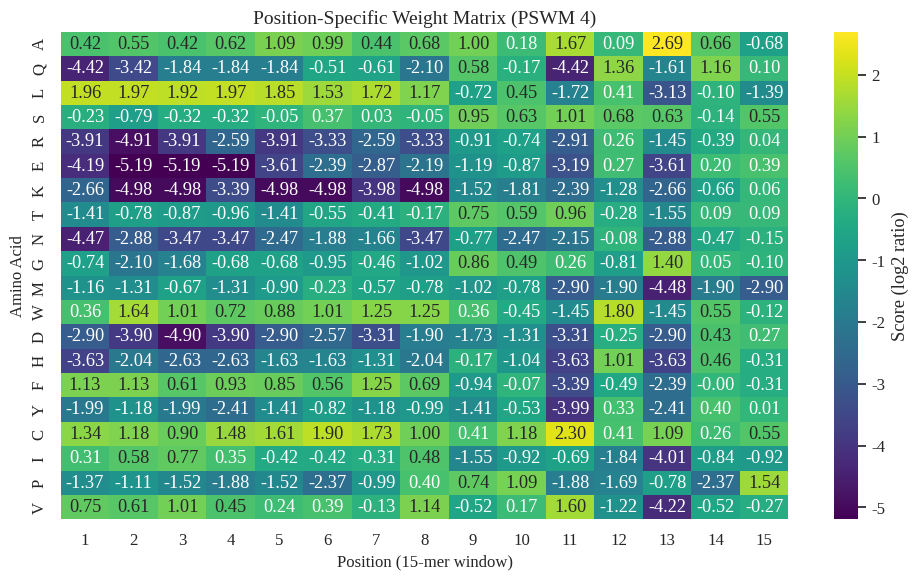

Validation Set Round 4
525    MELALRRSPVPRWLLLLPLLLGLNAGAVIDWPTEEGKEVWDYVTVR...
526    MGDHLDLLLGVVLMAGPVFGIPSCSFDGRIAFYRFCNLTQVPQVLN...
Name: Frag_90, dtype: object
6590    MALEAAFSMSFCSFSVPKAIFCERETSSFQRITSRAKGIAGESQVQ...
6591    MPHRKERPSGSSLHTHGSTGTAEGGNMSRLSLTRSPVSPLAAQGIP...
Name: Frag_90, dtype: object
Validation sequences processed: 1604

Optimal threshold for round 4: 8.65721442477617



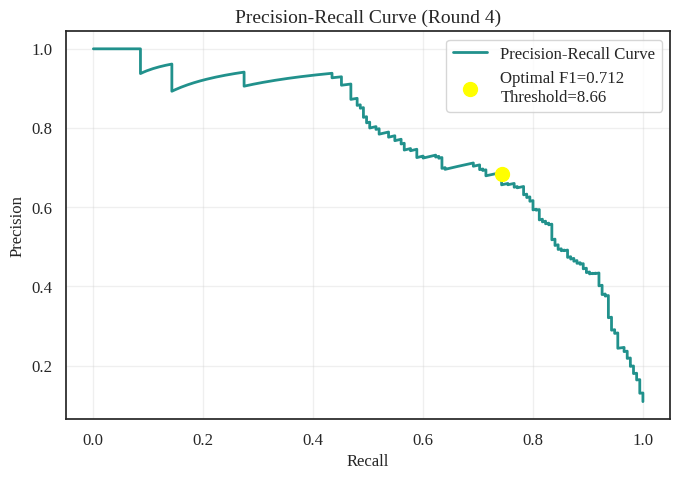

Testing Set Round 4
700    MRLSVCLLMVSLALCCYQAHALVCPAVASEITVFLFLSDAAVNLQV...
701    MARTGALLLVALALAGCAQACIYKFGTSPDSKATVSGDHWDHGLNG...
Name: Frag_90, dtype: object
8019    MELCRSLALLGGSLGLMFCLIALSTDFWFEAVGPTHSAHSGLWPTG...
8020    MVSLVNSSLTCSSLTLNLLPILRTETPSLSRKRRAAYVAATSSRDV...
Name: Frag_90, dtype: object
Testing samples: 1603

TP = 138 FP = 61 FN = 36 TN = 1368


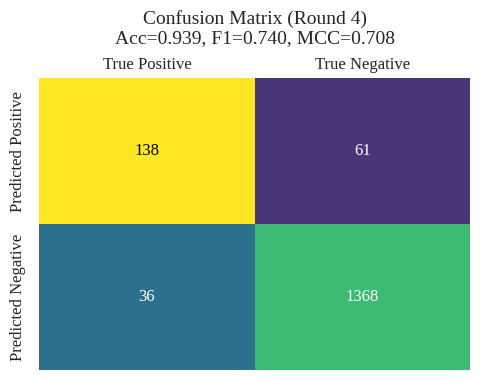


ROUND 5
Training Set Round 5
0    ILLSVALLAFSSAQD
1    LAVIGALLAVGATKV
dtype: object
523    LLLLLLLPSPLHPHP
524    LLLLLLRMSPSWSVV
dtype: object

pswm_5
[[ 0.46354596  0.59681249  0.09431215  0.48662957  1.09431215  0.90166707
   0.48662957  0.90166707  0.91874059 -0.06438559  1.76673749  0.23727011
   2.58616525  0.83127775 -0.68329543]
 [-4.42078554 -4.42078554 -1.83582304 -1.83582304 -1.61343062 -0.83582304
  -0.51389495 -2.09885745  0.53341077 -0.3333227  -3.42078554  1.03864608
  -1.42078554  0.78866782  0.48610505]
 [ 1.97819758  2.05949768  1.94292211  1.99895614  1.80827258  1.60663872
   1.70256314  1.05289495 -0.71528938  0.74414224 -1.13032688  0.47453518
  -3.13032688  0.01263108 -1.54536437]
 [-0.72017895 -1.00968557 -0.27271997 -0.59464807  0.06831694  0.43509927
  -0.32162958 -0.09214773  0.92891389  0.52082915  1.01021399  0.82038943
   0.60174914  0.17794143  0.60174914]
 [-3.325962   -4.9109245  -3.325962   -3.325962   -4.9109245  -3.325962
  -1.45149288 -3.325962   

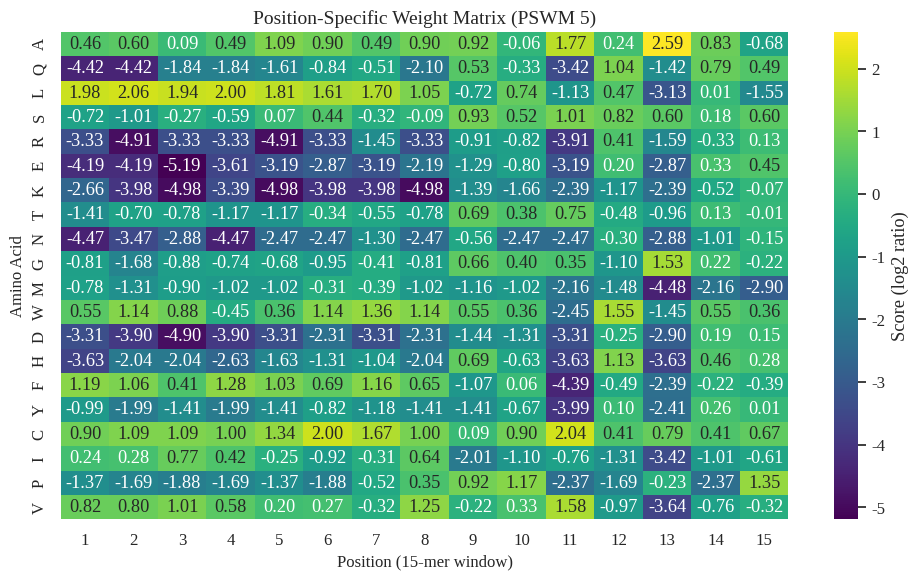

Validation Set Round 5
700    MRLSVCLLMVSLALCCYQAHALVCPAVASEITVFLFLSDAAVNLQV...
701    MARTGALLLVALALAGCAQACIYKFGTSPDSKATVSGDHWDHGLNG...
Name: Frag_90, dtype: object
8019    MELCRSLALLGGSLGLMFCLIALSTDFWFEAVGPTHSAHSGLWPTG...
8020    MVSLVNSSLTCSSLTLNLLPILRTETPSLSRKRRAAYVAATSSRDV...
Name: Frag_90, dtype: object
Validation sequences processed: 1603

Optimal threshold for round 5: 9.844249747133889



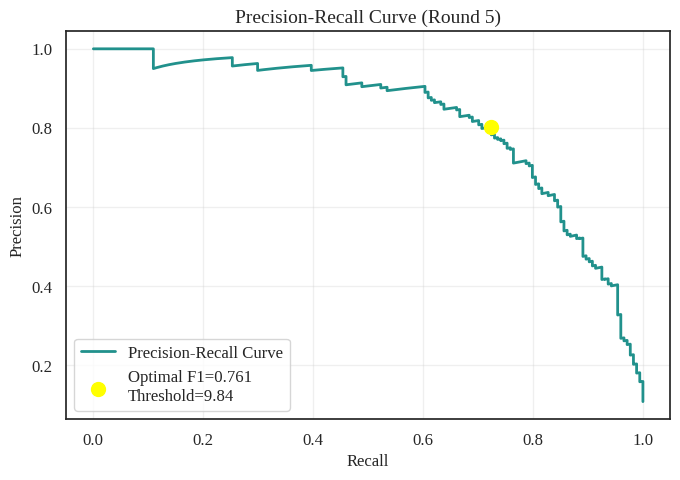

Testing Set Round 5
0    MRLLPLLRTVLWAAFLGSPLRGGSSLRHVVYWNSSNPRLLRGDAVV...
1    MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAG...
Name: Frag_90, dtype: object
2302    MDGGHSPDRHAAAAAGEPVRSRWTPKPEQILILESIFNSGMVNPPK...
2303    MAASGLDHLKNGYRRRFCRPSRARDINTEQGQNVLEILQDCFEEKS...
Name: Frag_90, dtype: object
Testing samples: 1605

TP = 111 FP = 29 FN = 64 TN = 1401


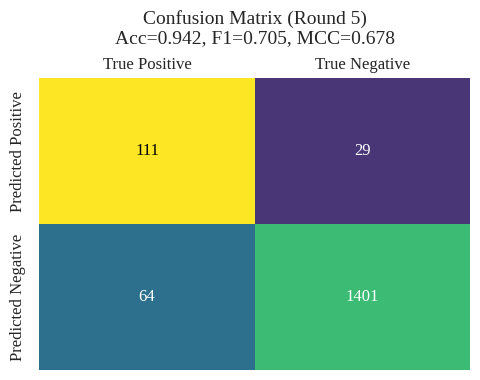


===== CROSS-VALIDATION SUMMARY =====
Accuracies: [0.93271028 0.91832918 0.9276808  0.93948846 0.94205607]
Precisions: [0.68715084 0.5990991  0.64251208 0.69346734 0.79285714]
Recalls: [0.70285714 0.76       0.76       0.79310345 0.63428571]
F1-scores: [0.69491525 0.67002519 0.69633508 0.73994638 0.7047619 ]
MCCs: [0.65715855 0.6299194  0.65859315 0.70791788 0.67822973]
Thresholds: [8.98906077 8.48579066 8.06817367 8.65721442 9.84424975]
Confusion matrices: [[(123, 56, 52, 1374)], [(133, 89, 42, 1340)], [(133, 74, 42, 1355)], [(138, 61, 36, 1368)], [(111, 29, 64, 1401)]]
Average Accuracy: 0.9321
Average Precision: 0.6830
Average Recall: 0.7300
Average F1-score: 0.7012
Average MCC: 0.6664
Standard Deviation Accuracy: 0.0085
Standard Deviation Precision: 0.0646
Standard Deviation Recall: 0.0560
Standard Deviation F1-score: 0.0226
   Accuracy  Precision    Recall  F1-score       MCC  Threshold
0  0.932710   0.687151  0.702857  0.694915  0.657159   8.989061
1  0.918329   0.599099  0.760000

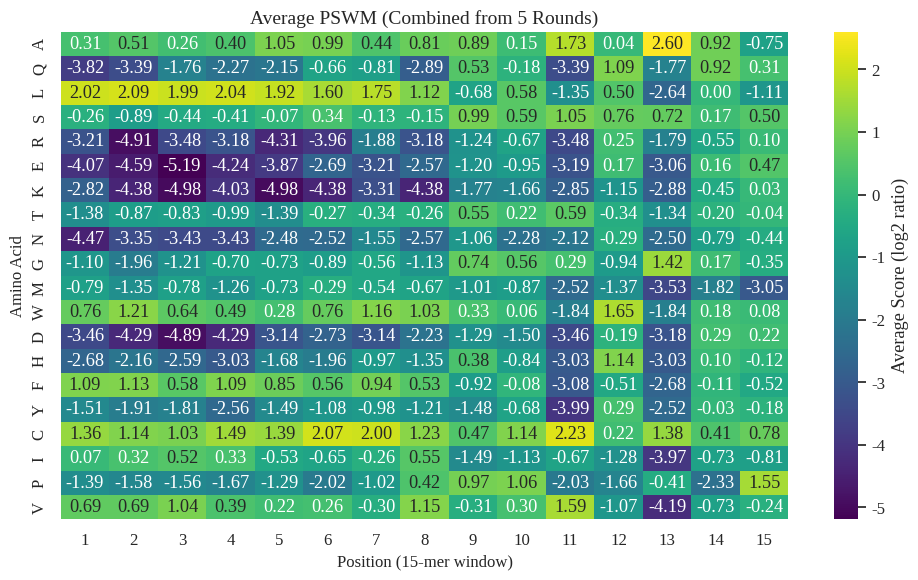

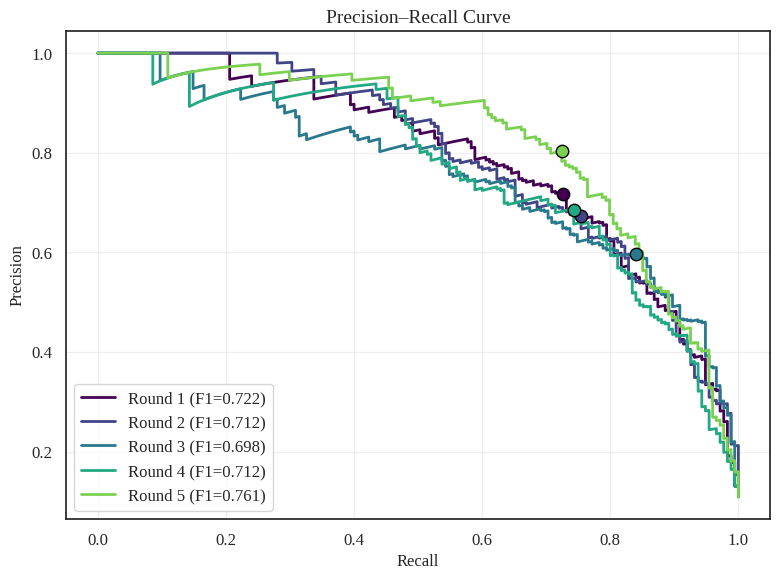

TP= 638 FP= 309 FN= 236 TN= 6838


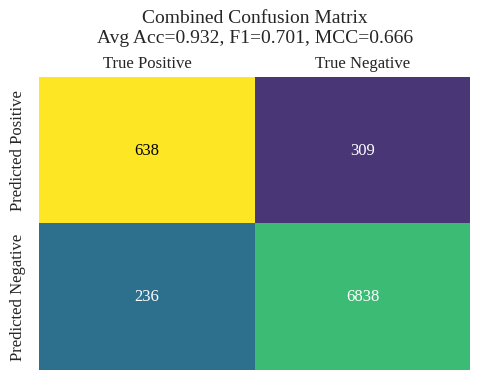

In [18]:
# --- CROSS-VALIDATION SETUP ---
cycles = 5
training, validation, testing = cross_val(cycles)

# --- INITIALIZE METRICS ---
confusions = [[] for _ in range(cycles)]
accuracies = np.array([])
precisions = np.array([])
recalls = np.array([])
f1s = np.array([])
mccs = np.array([])
ths = np.array([])
pr_data = []
pswm_list = []

# --- CROSS-VALIDATION LOOP ---
for i in range(cycles):
    print(f"\n{'='*30}\nROUND {i+1}\n{'='*30}")

    # -------------------- TRAINING --------------------
    sp_15 = pd.Series([], dtype=object)
    for el in training[i]:
        df_pswm = df[df['Class'] == 1]
        df_pswm = df_pswm[df_pswm['Label'] == el]
        sp_15 = pd.concat([sp_15, df_pswm['SP_15']])

    sp_15 = sp_15.reset_index(drop=True)

    print(f"Training Set Round {i+1}")
    print(sp_15.head(2))
    print(sp_15.tail(2))
    print("")

    pswm = compute_matrix(sp_15, f'pswm_{i+1}')
    pswm_list.append(pswm)
    print(f"pswm_{i+1}")
    print(pswm)
    print("")

    #Create the PSWM heatmap
    alphabet = list("AQLSREKTNGMWDHFYCIPV")

    plt.figure(figsize=(10, 6))
    sns.heatmap(pswm,cmap="viridis",annot=True,fmt=".2f",yticklabels=alphabet,xticklabels=range(1, pswm.shape[1] + 1),cbar_kws={'label': 'Score (log2 ratio)'})

    plt.title(f"Position-Specific Weight Matrix (PSWM {i+1})", fontsize=14)
    plt.xlabel("Position (15-mer window)", fontsize=12)
    plt.ylabel("Amino Acid", fontsize=12)
    plt.tight_layout()
    plt.show()
    #plt.savefig(f"PSWM_round{i+1}.pdf", dpi=1000, format="pdf",bbox_inches="tight",pad_inches=0.2)
    #plt.clf()

    # -------------------- VALIDATION --------------------
    sequences_val = df[df['Label'] == validation[i]]['Frag_90']
    validation_classes = df[df['Label'] == validation[i]]['Class']

    print(f"Validation Set Round {i+1}")
    print(sequences_val.head(2))
    print(sequences_val.tail(2))

    validation_scores = np.zeros(len(sequences_val))
    for j in range(len(sequences_val)):
        validation_scores[j] = compute_score(sequences_val.iloc[j], 15, pswm)

    print(f"Validation sequences processed: {len(validation_scores)}\n")

    # -------------------- THRESHOLD SELECTION --------------------
    precision_vals, recall_vals, thresholds = precision_recall_curve(validation_classes, validation_scores)
    fscore = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-15)
    index = np.argmax(fscore)
    optimal_threshold = thresholds[index]
    optimal_precision = precision_vals[index]
    optimal_recall = recall_vals[index]
    optimal_f1 = fscore[index]
    pr_data.append((precision_vals, recall_vals, index, i+1))

    print(f"Optimal threshold for round {i+1}: {optimal_threshold}\n")

    # Precision - Recall Curve plot (single round)
    plt.figure(figsize=(7, 5))
    line_color = cm.viridis(0.5)
    plt.plot(recall_vals, precision_vals, color=line_color, lw=2, label='Precision-Recall Curve')
    plt.scatter(optimal_recall, optimal_precision, color='yellow', s=100, label=f'Optimal F1={optimal_f1:.3f}\nThreshold={optimal_threshold:.2f}', zorder=5)


    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve (Round {i+1})', fontsize=14)
    plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    #plt.savefig(f"PRC_round{i+1}.pdf", dpi=1000, format="pdf",bbox_inches="tight",pad_inches=0.2)
    #plt.clf()

    # -------------------- TESTING --------------------
    testing_sequences = df[df['Label'] == testing[i]]['Frag_90']
    testing_classes = df[df['Label'] == testing[i]]['Class']

    testing_scores = np.zeros(len(testing_sequences))
    for j in range(len(testing_sequences)):
        testing_scores[j] = compute_score(testing_sequences.iloc[j], 15, pswm)

    predictions = np.where(testing_scores >= optimal_threshold, 1, 0)

    print(f"Testing Set Round {i+1}")
    print(testing_sequences.head(2))
    print(testing_sequences.tail(2))
    print(f"Testing samples: {len(testing_sequences)}\n")

    # -------------------- METRICS --------------------
    TP, FP, FN, TN = compute_confusion_matrix(predictions, testing_classes.to_numpy())
    print('TP =', TP, 'FP =', FP, 'FN =', FN, 'TN =', TN)

    acc = accuracy(TP, FP, FN, TN)
    rec = recall(TP, FP, FN, TN)
    prec = precision(TP, FP, FN, TN)
    f1 = f1_score(prec, rec)
    MCC = mcc(TP, FP, FN, TN)

    # Store metrics
    confusions[i].append((TP, FP, FN, TN))
    accuracies = np.append(accuracies, acc)
    recalls = np.append(recalls, rec)
    precisions = np.append(precisions, prec)
    f1s = np.append(f1s, f1)
    mccs = np.append(mccs, MCC)
    ths = np.append(ths, optimal_threshold)

    avg_acc = np.mean(accuracies)
    avg_rec = np.mean(recalls)
    avg_prec = np.mean(precisions)
    avg_f1 = np.mean(f1s)
    avg_mcc = np.mean(mccs)

    std_acc = np.std(accuracies)
    std_rec = np.std(recalls)
    std_prec = np.std(precisions)
    std_f1 = np.std(f1s)

    runs_df = pd.DataFrame({
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-score': f1s,
        'MCC': mccs,
        'Threshold': ths
    })

    metrics_summary = pd.DataFrame({
      "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "MCC", "Threshold"],
      "Average": [
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1s),
        np.mean(mccs),
        np.mean(ths)
      ],
      "Standard Deviation": [
        np.std(accuracies),
        np.std(precisions),
        np.std(recalls),
        np.std(f1s),
        np.std(mccs),
        np.std(ths)
      ]
    })

    # Confusion Matrix
    plot_cm = np.array([[TP, FP],
                        [FN, TN]])

    cell_colors = np.array([['#fde725ff', '#483677ff'],
                            ['#2d708eff', '#3cbb75ff']])

    fig, ax = plt.subplots(figsize=(5, 4))

    for r in range(2):
        for c in range(2):
            ax.add_patch(plt.Rectangle((c, 1-r), 1, 1, color=cell_colors[r, c], edgecolor=None, linewidth=0))
            text_color = 'black' if (r, c) == (0, 0) else 'white'
            ax.text(c + 0.5, 1.5 - r, plot_cm[r, c],
                    ha='center', va='center', fontsize=12,
                    fontfamily='Liberation Serif', color=text_color)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)

    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['True Positive', 'True Negative'], fontname='Liberation Serif')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(['Predicted Negative', 'Predicted Positive'], rotation=90, va='center', fontname='Liberation Serif')

    ax.set_title(f'Confusion Matrix (Round {i+1})\nAcc={acc:.3f}, F1={f1:.3f}, MCC={MCC:.3f}', fontsize=14, fontfamily='Liberation Serif', pad=10)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()

    #plt.savefig(f"CM_round{i+1}.pdf", dpi=1000, format="pdf", bbox_inches="tight",pad_inches=0.2)
    #plt.close()

#runs_df.to_csv("runs_report.csv", index=True)
#summary_df.to_csv("metrics_report.csv", index=True)

# --- SUMMARY ---
print("\n===== CROSS-VALIDATION SUMMARY =====")
print(f"Accuracies: {accuracies}")
print(f"Precisions: {precisions}")
print(f"Recalls: {recalls}")
print(f"F1-scores: {f1s}")
print(f"MCCs: {mccs}")
print(f"Thresholds: {ths}")
print(f"Confusion matrices: {confusions}")

print(f"Average Accuracy: {avg_acc:.4f}")
print(f"Average Precision: {avg_prec:.4f}")
print(f"Average Recall: {avg_rec:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")
print(f"Average MCC: {avg_mcc:.4f}")

print(f"Standard Deviation Accuracy: {std_acc:.4f}")
print(f"Standard Deviation Precision: {std_prec:.4f}")
print(f"Standard Deviation Recall: {std_rec:.4f}")
print(f"Standard Deviation F1-score: {std_f1:.4f}")

print(runs_df)
print(metrics_summary)

# Combined PSWMs

combined_pswm = np.mean(np.stack(pswm_list), axis=0)
alphabet = list("AQLSREKTNGMWDHFYCIPV")

plt.figure(figsize=(10, 6))
sns.heatmap(combined_pswm,cmap="viridis",annot=True,fmt=".2f",yticklabels=alphabet,xticklabels=range(1, combined_pswm.shape[1] + 1),cbar_kws={'label': 'Average Score (log2 ratio)'})
plt.title("Average PSWM (Combined from 5 Rounds)", fontsize=14, fontfamily='Liberation Serif')
plt.xlabel("Position (15-mer window)", fontsize=12, fontfamily='Liberation Serif')
plt.ylabel("Amino Acid", fontsize=12, fontfamily='Liberation Serif')
plt.tight_layout()
plt.show()

#plt.savefig("PSWMs_all_rounds.pdf", dpi=1000, format="pdf", bbox_inches="tight",pad_inches=0.2)
#plt.clf()

# Combined PR-curves
plt.figure(figsize=(8, 6))
cmap = plt.colormaps.get_cmap('viridis')

for i, (precision_vals, recall_vals, index, round_num) in enumerate(pr_data):
    optimal_precision = precision_vals[index]
    optimal_recall = recall_vals[index]
    fscore = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-15)
    optimal_f1 = fscore[index]

    line_color = cmap(i / cycles)
    plt.plot(recall_vals, precision_vals, color=line_color, lw=2, label=f'Round {round_num} (F1={optimal_f1:.3f})')
    plt.scatter(optimal_recall, optimal_precision, color=line_color, s=80, edgecolor='black', zorder=5)

plt.xlabel('Recall', fontsize=12, fontfamily='Liberation Serif')
plt.ylabel('Precision', fontsize=12, fontfamily='Liberation Serif')
plt.title('Precision–Recall Curve', fontsize=14, fontfamily='Liberation Serif')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#plt.savefig("PRC_all_rounds.pdf", dpi=1000, format="pdf", bbox_inches="tight",pad_inches=0.2)
#plt.clf()

# Combined CM
combined_cm = np.zeros((2,2), dtype=int)
for cm_tuple in confusions:
    for TP_i, FP_i, FN_i, TN_i in cm_tuple:
        combined_cm += np.array([[TP_i, FP_i],
                                 [FN_i, TN_i]])

print('TP=', combined_cm[0,0], 'FP=', combined_cm[0,1], 'FN=', combined_cm[1,0], 'TN=', combined_cm[1,1])

fig, ax = plt.subplots(figsize=(5, 4))

for r in range(2):
    for c in range(2):
        ax.add_patch(plt.Rectangle((c, 1-r), 1, 1, color=cell_colors[r,c], edgecolor=None, linewidth=0))
        text_color = 'black' if (r,c) == (0,0) else 'white'
        ax.text(c+0.5, 0.5+r*-1+1, combined_cm[r,c],
                ha='center', va='center', fontsize=12, fontfamily='Liberation Serif', color=text_color)

ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['True Positive', 'True Negative'], fontname='Liberation Serif')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='both', length=0)

ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(['Predicted Negative', 'Predicted Positive'], rotation=90, va='center', fontname='Liberation Serif')

ax.set_title(f'Combined Confusion Matrix\nAvg Acc={avg_acc:.3f}, F1={avg_f1:.3f}, MCC={avg_mcc:.3f}',
             fontsize=14, fontfamily='Liberation Serif', pad=10)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

#plt.savefig("CM_all_rounds.pdf", dpi=1000, format="pdf", bbox_inches="tight",pad_inches=0.2)
#plt.clf()
